# **Homework on Credit Risk**
## **Building an Application Scoring Model**

### **General Information**
- **Date assigned:** December 2, 2025  
- **Soft deadline:** 23:59 MSK, December 15, 2025  
- **Hard deadline:** 23:59 MSK, December 18, 2025  
- **Submission:** send your work to  
  \texttt{maria.vorobyova.ser@gmail.com}  
  with the subject format:
  \[
  \text{HSE\_CS\_[track]\_FullName}
  \]
  Example:
  \[
  \text{HSE\_CS\_PAD\_IVANOV\_IVAN\_IVANOVICH}
  \]

---

### **Grading and Penalties**
Maximum score: **10 points**

Late penalty:
\[
\text{Final Score} = 10 - \text{days late}
\]

Submission **after** the hard deadline is **not accepted**.

Work must be completed **independently**.  
Similar solutions → **plagiarism** → score **0**.

---

### **Score Reduction If**
- no comments in the notebook
- unclear or poorly written code
- incorrect analysis and conclusions

---

### **Task**
Build a scoring model estimating the **probability of default** at the **credit application stage**.

Follow the provided notebook strictly and complete every block.

---

### **Dataset**
Based on Kaggle competition:
\[
\text{Give Me Some Credit}
\]

Data source:  
https://www.kaggle.com/competitions/GiveMeSomeCredit/data  

Data description:  
**Data Dictionary.xlsx**



# **Work assignment:**
**1.Explatory Data Analysis - (Task weight: 20%)**

**2.Creating additional variables - (Task weight: 10%)**

**3. Model building (A logistic regression must be built on the WoE variables.)- (Task weight: 50%)**

**4. Using methods to reduce class imbalance - (Task weight: 20%)**

# **Submitting results:**

* Submit homework via the Yandex form as a link to your GitHub, where all files and code (Python) will be.
* GitHub must be open and the code must be working, without errors.
* Name the repository using the template (HW_4_2025-FirstName_LastName).
* Link to the Yandex form: https://forms.yandex.ru/u/68eece24505690c23425594c

We wish you good luck!✌

# Additional explanations for the task

In [33]:
from google.colab import drive
import json
import zipfile

import pandas as pd

In [34]:
def load_dataset(from_kaggle:bool = False) -> pd.DataFrame:
  '''
  The function downloads data from the Kaggle website if from_kaggle=True is set.
Otherwise, the archive is read from a Google Drive link (this method is convenient for those who don't have access to Kaggle).
  params:
      - from_kaggle - индикатор откуда скачивать данные (True - c сайта kaggle, False -  c google диска)
  return:
      - pd.DataFrame

  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c GiveMeSomeCredit
  else:
    !gdown 1MRYG6P6ScMTzTmXJlWdPdYQVNi04wLSm
  # распаковка архива
  zip_ref = zipfile.ZipFile('GiveMeSomeCredit.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('cs-training.csv')
  df_test = pd.read_csv('cs-test.csv')
  return df_train, df_test

In [35]:
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')

In [36]:
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# 1.Explatory Data Analysis. Максимально - (20%-2 балла)

- 0 points if the task is not completed
- 1 point if statistics are calculated and there are logical graphs (important, USEFUL graphs), but no conclusions are drawn
- 2 points if statistics are calculated and there are graphs (important, USEFUL graphs) and CONCLUSIONS are drawn (important, that the conclusions are correct)

In [38]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

display(df_train.head())

display(df_train.describe(include="all").T)

na = df_train.isna().sum().sort_values(ascending=False)
display(na[na>0].to_frame("missing_cnt"))

display((df_train.isna().mean().sort_values(ascending=False)).to_frame("missing_share"))

Train shape: (150000, 12)
Test shape: (101503, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


,missing_cnt
MonthlyIncome,29731
NumberOfDependents,3924


,missing_share
MonthlyIncome,0.198207
NumberOfDependents,0.026160
Unnamed: 0,0.000000
SeriousDlqin2yrs,0.000000
age,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
DebtRatio,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000


Default rate: 0.06684


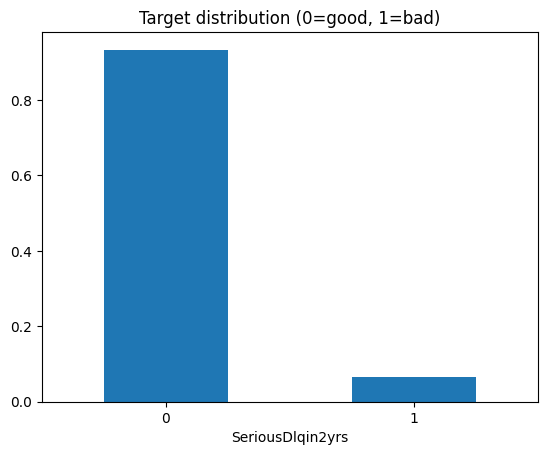

In [39]:
target = "SeriousDlqin2yrs"
y = df_train[target]

print("Default rate:", y.mean())

plt.figure()
y.value_counts(normalize=True).sort_index().plot(kind="bar")
plt.title("Target distribution (0=good, 1=bad)")
plt.xticks(rotation=0)
plt.show()

,corr_with_target
age,-0.115386
NumberOfOpenCreditLinesAndLoans,-0.029669
MonthlyIncome,-0.019746
DebtRatio,-0.007602
NumberRealEstateLoansOrLines,-0.007038
RevolvingUtilizationOfUnsecuredLines,-0.001802
Unnamed: 0,0.002801
NumberOfDependents,0.046048
NumberOfTime60-89DaysPastDueNotWorse,0.102261
NumberOfTimes90DaysLate,0.117175


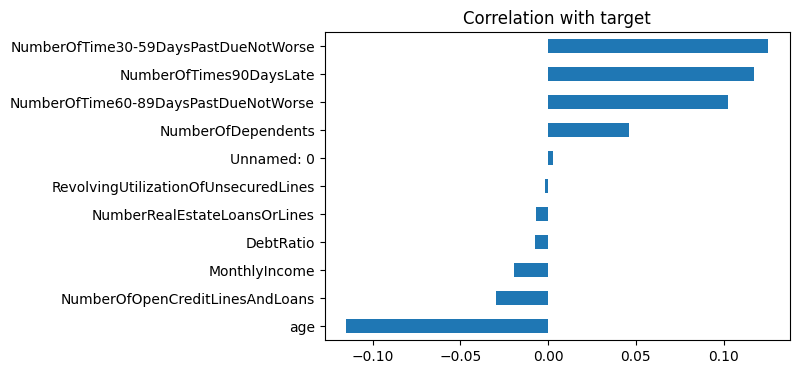

In [40]:
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]

corr = df_train[[target] + num_cols].corr(numeric_only=True)[target].sort_values()
display(corr.to_frame("corr_with_target"))

plt.figure(figsize=(6,4))
corr.drop(target).plot(kind="barh")
plt.title("Correlation with target")
plt.show()

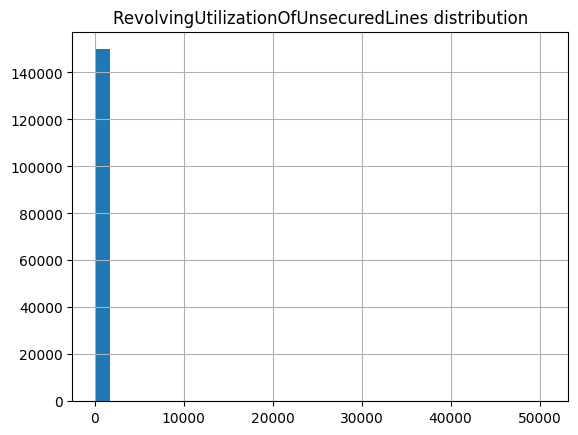

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


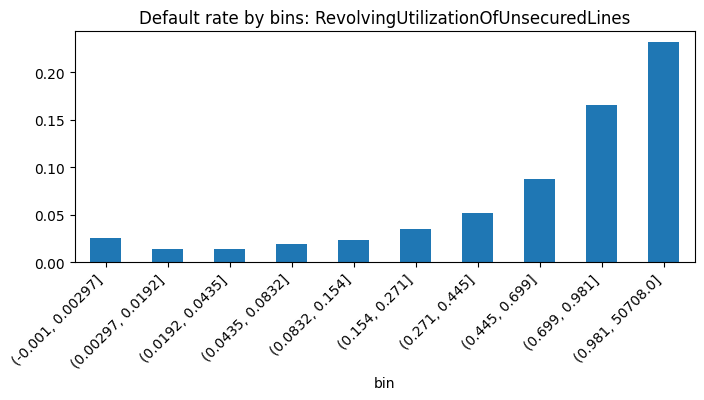

,bin,cnt,default_rate
0,"(-0.001, 0.00297]",15000,0.025200
1,"(0.00297, 0.0192]",15000,0.013600
2,"(0.0192, 0.0435]",15000,0.014000
3,"(0.0435, 0.0832]",15000,0.019133
4,"(0.0832, 0.154]",15000,0.023733
5,"(0.154, 0.271]",15000,0.034733
6,"(0.271, 0.445]",15000,0.052467
7,"(0.445, 0.699]",15000,0.088000
8,"(0.699, 0.981]",15000,0.165867
9,"(0.981, 50708.0]",15000,0.231667


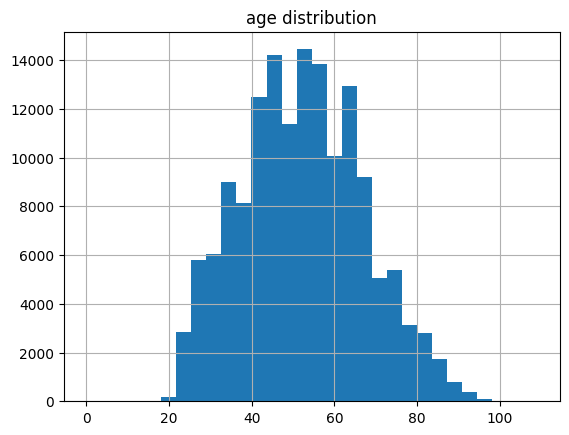

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


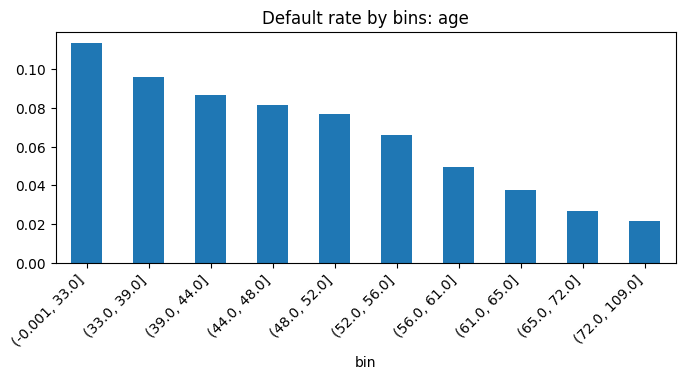

,bin,cnt,default_rate
0,"(-0.001, 33.0]",17085,0.113550
1,"(33.0, 39.0]",14919,0.095851
2,"(39.0, 44.0]",15799,0.086398
3,"(44.0, 48.0]",14741,0.081406
4,"(48.0, 52.0]",14826,0.077027
5,"(52.0, 56.0]",14214,0.065780
6,"(56.0, 61.0]",16878,0.049710
7,"(61.0, 65.0]",12939,0.037484
8,"(65.0, 72.0]",14258,0.026652
9,"(72.0, 109.0]",14341,0.021616


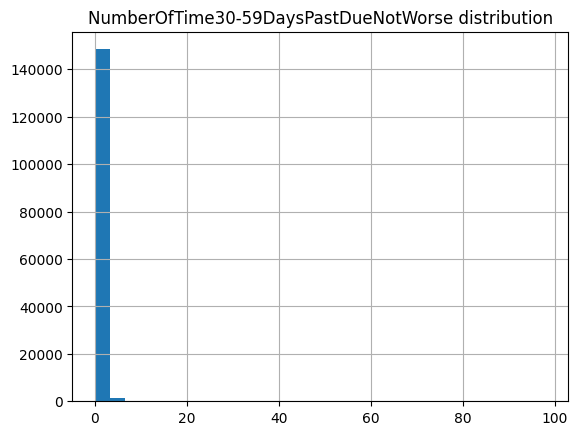

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


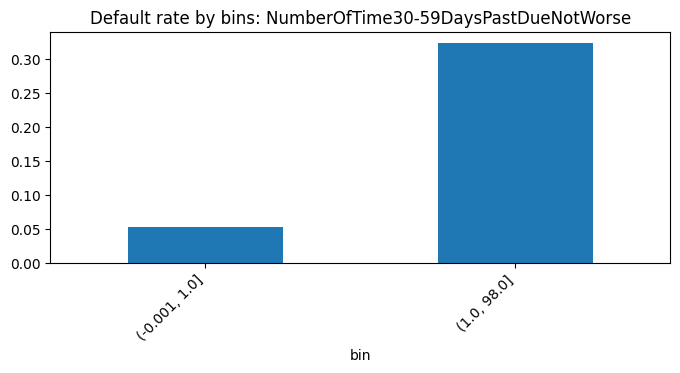

,bin,cnt,default_rate
0,"(-0.001, 1.0]",142051,0.052446
1,"(1.0, 98.0]",7949,0.324066


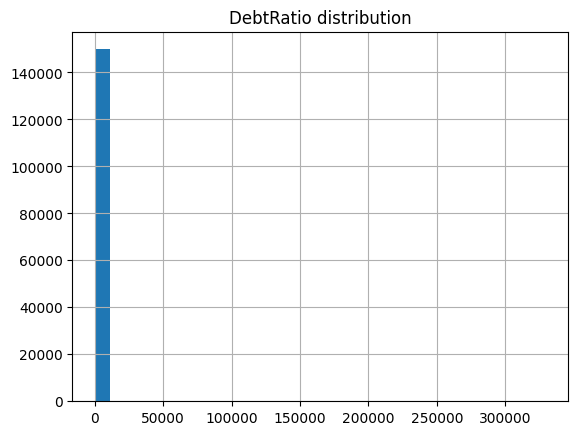

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


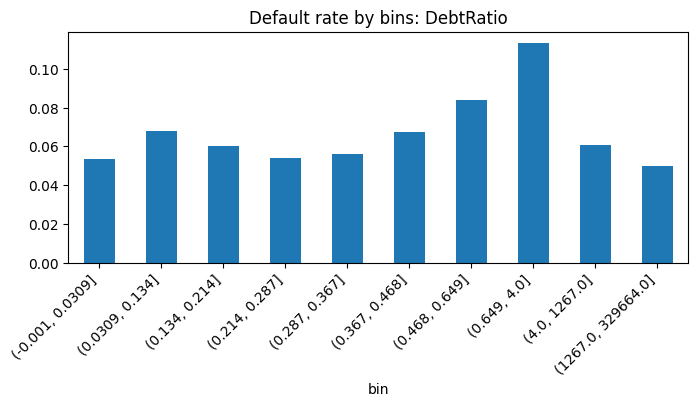

,bin,cnt,default_rate
0,"(-0.001, 0.0309]",15000,0.053800
1,"(0.0309, 0.134]",15000,0.068200
2,"(0.134, 0.214]",15000,0.060333
3,"(0.214, 0.287]",15000,0.054067
4,"(0.287, 0.367]",15000,0.056133
5,"(0.367, 0.468]",15000,0.067400
6,"(0.468, 0.649]",15001,0.084128
7,"(0.649, 4.0]",15108,0.113317
8,"(4.0, 1267.0]",14896,0.060822
9,"(1267.0, 329664.0]",14995,0.049817


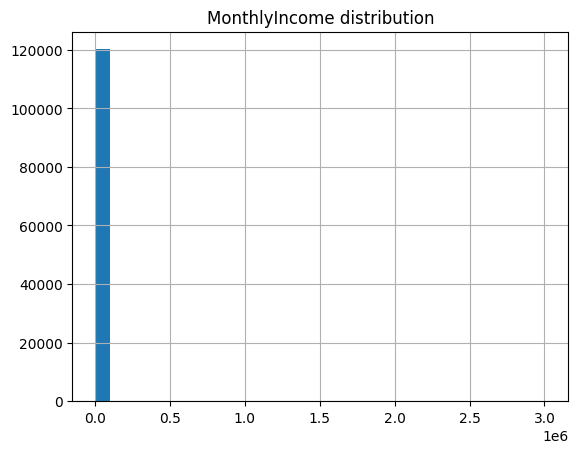

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


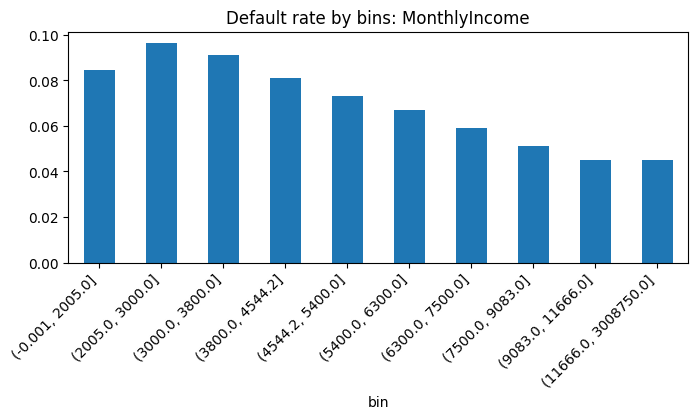

,bin,cnt,default_rate
0,"(-0.001, 2005.0]",12028,0.084386
1,"(2005.0, 3000.0]",13056,0.096661
2,"(3000.0, 3800.0]",11322,0.091150
3,"(3800.0, 4544.2]",11702,0.080926
4,"(4544.2, 5400.0]",12207,0.073319
5,"(5400.0, 6300.0]",11850,0.066835
6,"(6300.0, 7500.0]",12351,0.059266
7,"(7500.0, 9083.0]",11733,0.051138
8,"(9083.0, 11666.0]",12110,0.045169
9,"(11666.0, 3008750.0]",11910,0.044920


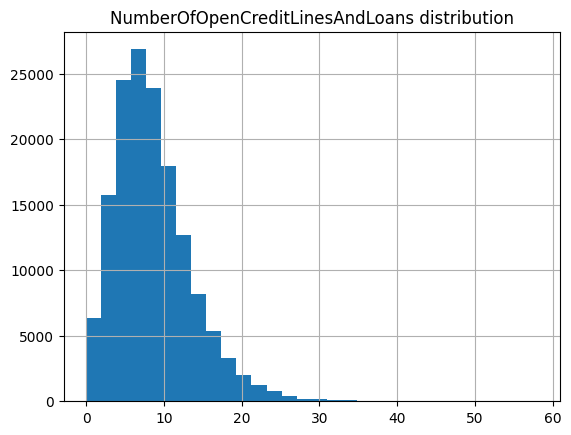

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


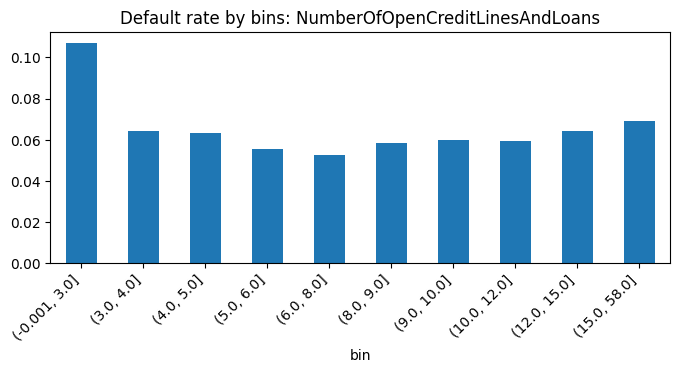

,bin,cnt,default_rate
0,"(-0.001, 3.0]",22050,0.107029
1,"(3.0, 4.0]",11609,0.064002
2,"(4.0, 5.0]",12931,0.063336
3,"(5.0, 6.0]",13614,0.055384
4,"(6.0, 8.0]",25807,0.052428
5,"(8.0, 9.0]",11355,0.058476
6,"(9.0, 10.0]",9624,0.059643
7,"(10.0, 12.0]",15326,0.059572
8,"(12.0, 15.0]",13858,0.064295
9,"(15.0, 58.0]",13826,0.069073


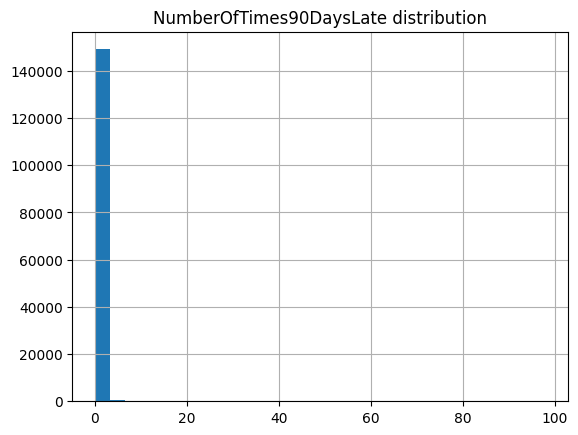

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


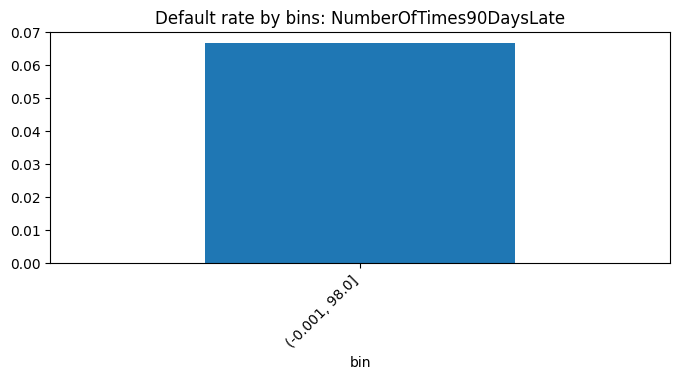

,bin,cnt,default_rate
0,"(-0.001, 98.0]",150000,0.06684


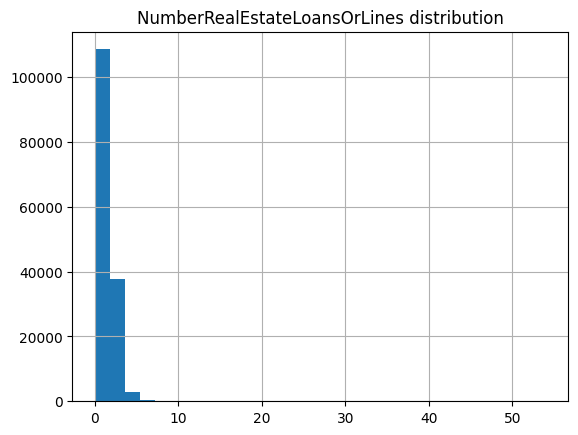

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


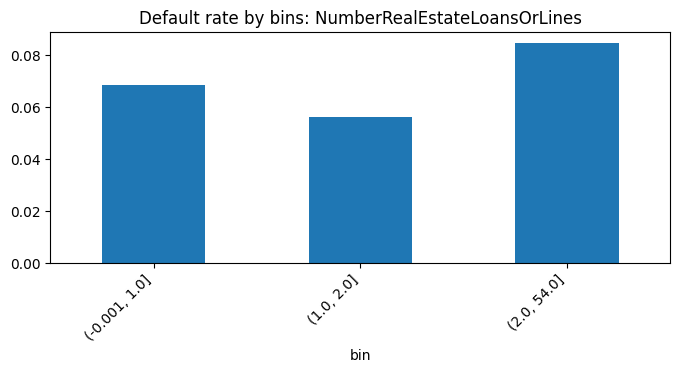

,bin,cnt,default_rate
0,"(-0.001, 1.0]",108526,0.068371
1,"(1.0, 2.0]",31522,0.055993
2,"(2.0, 54.0]",9952,0.084506


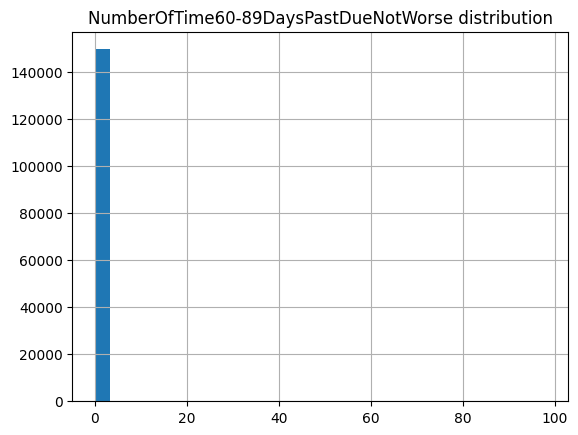

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


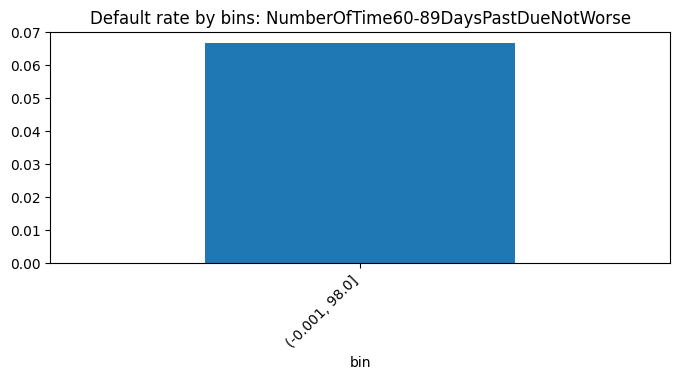

,bin,cnt,default_rate
0,"(-0.001, 98.0]",150000,0.06684


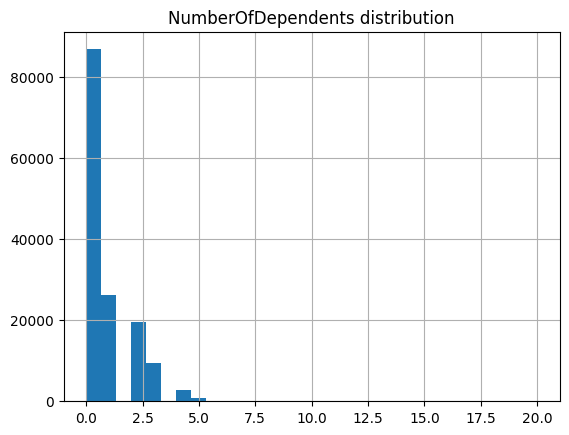

/tmp/ipython-input-4258723458.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("bin")[target].mean()
/tmp/ipython-input-4258723458.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = tmp.groupby("bin")[target].size()


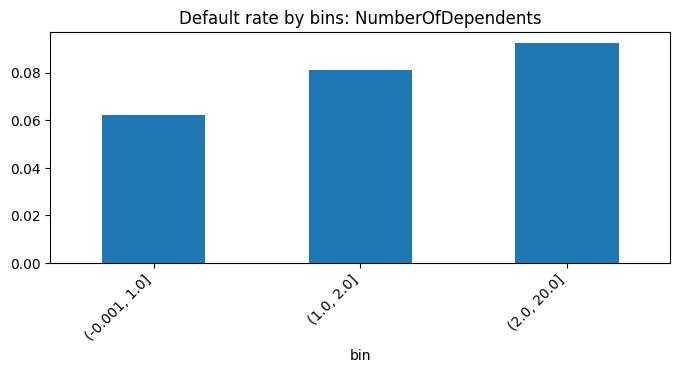

,bin,cnt,default_rate
0,"(-0.001, 1.0]",113218,0.062093
1,"(1.0, 2.0]",19522,0.081139
2,"(2.0, 20.0]",13336,0.092457


In [41]:
def plot_feature_vs_target(df, col, target=target, bins=10):
    s = df[col]
    plt.figure()
    if pd.api.types.is_numeric_dtype(s):
        s.replace([np.inf, -np.inf], np.nan).dropna().hist(bins=30)
        plt.title(f"{col} distribution")
        plt.show()


        tmp = df[[col, target]].copy()
        tmp[col] = tmp[col].replace([np.inf, -np.inf], np.nan)
        tmp = tmp.dropna(subset=[col, target])

        tmp["bin"] = pd.qcut(tmp[col], q=bins, duplicates="drop")
        rate = tmp.groupby("bin")[target].mean()
        cnt = tmp.groupby("bin")[target].size()

        plt.figure(figsize=(8,3))
        rate.plot(kind="bar")
        plt.title(f"Default rate by bins: {col}")
        plt.xticks(rotation=45, ha="right")
        plt.show()

        display(pd.DataFrame({"cnt": cnt, "default_rate": rate}).reset_index())
    else:

        plt.figure(figsize=(8,3))
        df[col].value_counts().head(20).plot(kind="bar")
        plt.title(f"{col} top categories")
        plt.xticks(rotation=45, ha="right")
        plt.show()

        rate = df.groupby(col)[target].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,3))
        rate.plot(kind="bar")
        plt.title(f"Default rate by category: {col}")
        plt.xticks(rotation=45, ha="right")
        plt.show()

features_to_check = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents"
]

for c in features_to_check:
    if c in df_train.columns:
        plot_feature_vs_target(df_train, c, bins=10)

In [42]:

print("age==0:", (df_train["age"] == 0).sum())
print("MonthlyIncome missing:", df_train["MonthlyIncome"].isna().sum())
print("NumberOfDependents missing:", df_train["NumberOfDependents"].isna().sum())

late_cols = [
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate"
]
for c in late_cols:
    if c in df_train.columns:
        display(df_train[c].value_counts().head(10).to_frame("top_values"))

age==0: 1
MonthlyIncome missing: 29731
NumberOfDependents missing: 3924


,top_values
NumberOfTime30-59DaysPastDueNotWorse,
0,126018
1,16033
2,4598
3,1754
4,747
5,342
98,264
6,140
7,54


,top_values
NumberOfTime60-89DaysPastDueNotWorse,
0,142396
1,5731
2,1118
3,318
98,264
4,105
5,34
6,16
7,9


,top_values
NumberOfTimes90DaysLate,
0,141662
1,5243
2,1555
3,667
4,291
98,264
5,131
6,80
7,38


The target variable is highly imbalanced, with a default rate of about 6.7%.
Missing values are mainly present in MonthlyIncome and NumberOfDependents, while other variables have no missing data.
Variables related to payment delays show the strongest relationship with default and are highly informative.
Default risk increases for younger clients and for higher credit utilization, which makes these variables important for the scoring model.

# 2.Creating additional variables - (Task weight: 10%)

Be creative: the more variables, the higher the score! However, variables must be logical; illogical variables will not be accepted.

- 0 points if the task is not completed.
- 0.5 points - 2 additional variables created.
- 1 point - more than 3 variables created.


In [43]:
df_train2 = df_train.copy()
df_test2  = df_test.copy()

def add_features(df):
    df = df.copy()

    late_30 = "NumberOfTime30-59DaysPastDueNotWorse"
    late_60 = "NumberOfTime60-89DaysPastDueNotWorse"
    late_90 = "NumberOfTimes90DaysLate"

    df["TotalPastDue"] = df[late_30] + df[late_60] + df[late_90]
    df["HasPastDue"] = (df["TotalPastDue"] > 0).astype(int)
    df["Any90Late"] = (df[late_90] > 0).astype(int)

    df["Util_x_OpenLines"] = df["RevolvingUtilizationOfUnsecuredLines"] * df["NumberOfOpenCreditLinesAndLoans"]

    if "MonthlyIncome" in df.columns:
        df["IncomePerPerson"] = df["MonthlyIncome"] / (df["NumberOfDependents"].fillna(0) + 1)
    df["IsYoung"] = (df["age"] < 25).astype(int)

    return df

df_train2 = add_features(df_train2)
df_test2 = add_features(df_test2)

print(df_train2.shape, df_test2.shape)
display(df_train2.head())

(150000, 18) (101503, 18)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalPastDue,HasPastDue,Any90Late,Util_x_OpenLines,IncomePerPerson,IsYoung
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,2,1,0,9.959646,3040.0,0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,0,3.828604,1300.0,0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,2,1,1,1.316360,3042.0,0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,0,1.169049,3300.0,0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1,1,0,6.350676,63588.0,0


Several additional features were created to better describe credit behavior and financial load of clients

New variables aggregate information about past due payments and credit utilization, which cannot be fully captured by original features alone.
The added features are intuitive from a credit risk perspective and increase the informational value of the dataset

These variables were included in further modeling to improve predictive performance

# 3. Model building - (Task weight: 50%)
A logistic regression must be built on the WoE variables.

- If any other model is built, the score is 0.

In [44]:
target = "SeriousDlqin2yrs"

drop_cols = []
for c in ["Unnamed: 0", "ID", "Id"]:
    if c in df_train2.columns:
        drop_cols.append(c)

X = df_train2.drop(columns=[target] + drop_cols)
y = df_train2[target].astype(int)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)
print("Train default rate:", y_train.mean(), "Test default rate:", y_test.mean())

(105000, 16) (45000, 16)
Train default rate: 0.06683809523809524 Test default rate: 0.06684444444444444


A WoE transformation must be calculated - maximum 3 points.

The WoE calculation must be done in two steps:

Step 1. Fine Classification (1 point). Splitting into a large number of bins (intervals).
- Typically, interval variables are divided into 20, 30, and so on intervals.
- For categorical variables, one category per group.
- Next, calculate the WoE for each group.

Step 2. Coarse Classification (2 points). Consolidating the intervals obtained in Step 1. The result should be no more than 5-10 intervals.
- Typically, groups with similar WoE values ​​are combined.
- The WoE must be monotonic, meaning that after your combination, the result must be interpretable (it is necessary to graphically demonstrate that the WoE is monotonic).


In [45]:
def woe_table_for_binned(x_binned: pd.Series, y: pd.Series, eps: float = 1e-6) -> pd.DataFrame:
    tmp = pd.DataFrame({"bin": x_binned, "y": y})
    g = tmp.groupby("bin", dropna=False)["y"]
    bad = g.sum()
    total = g.count()
    good = total - bad

    bad_total = bad.sum()
    good_total = good.sum()

    dist_bad = (bad + eps) / (bad_total + eps * len(bad))
    dist_good = (good + eps) / (good_total + eps * len(good))

    woe = np.log(dist_good / dist_bad)
    iv = (dist_good - dist_bad) * woe

    out = pd.DataFrame({
        "bin": bad.index.astype(str),
        "total": total.values,
        "good": good.values,
        "bad": bad.values,
        "dist_good": dist_good.values,
        "dist_bad": dist_bad.values,
        "woe": woe.values,
        "iv": iv.values
    })
    out["bad_rate"] = out["bad"] / out["total"]
    out = out.sort_values("woe").reset_index(drop=True)
    out["iv_total"] = out["iv"].sum()
    return out
def fine_binning(series: pd.Series, n_bins: int = 20) -> pd.Series:
    s = series.copy()
    s = s.replace([np.inf, -np.inf], np.nan)

    try:
        b = pd.qcut(s, q=n_bins, duplicates="drop")
    except ValueError:

        b = pd.cut(s, bins=min(n_bins, s.nunique()))
    return b

In [46]:
def coarse_from_fine(fine_bins: pd.Series, y: pd.Series, max_bins: int = 8) -> pd.Series:

    tab = woe_table_for_binned(fine_bins, y)

    order = tab["bin"].tolist()

    k = min(max_bins, len(order))
    groups = np.array_split(order, k)

    mapping = {}
    for i, grp in enumerate(groups):
        for b in grp:
            mapping[b] = f"G{i+1}"

    return fine_bins.astype(str).map(mapping).astype("category")

def woe_map_from_bins(x_bins: pd.Series, y: pd.Series) -> dict:
    tab = woe_table_for_binned(x_bins, y)
    return dict(zip(tab["bin"], tab["woe"]))

def plot_woe_monotonic(tab: pd.DataFrame, title: str):
    plt.figure(figsize=(8,3))
    plt.plot(range(len(tab)), tab["woe"].values, marker="o")
    plt.title(title)
    plt.xlabel("Bins ordered by WoE")
    plt.ylabel("WoE")
    plt.grid(True)
    plt.show()

Constructing and evaluating logistic regression - maximum 1 point
- Constructing only logistic regression - 0.3 points
- Evaluating the model (roc auc, f1, etc.) - 0.3 points
- Constructing a scorecard - 0.4 points

As a reminder, the following formulas are required for the scorecard (details in the lecture and seminar):
Score_i =  (βi × WoE_i + α/n) × Factor + Offset/n, где

- Factor = pdo/ln(2)

- Offset = Target Score — (Factor × ln(Target Odds))

/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


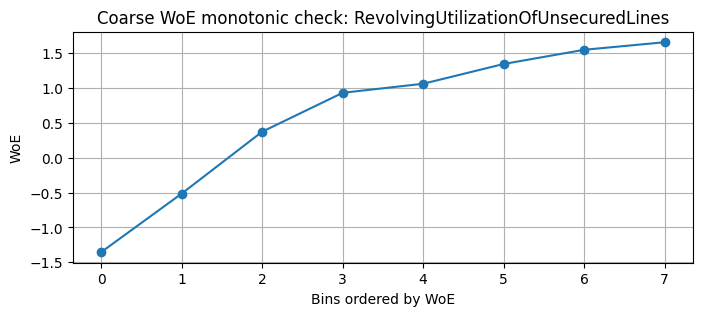

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15750,12326,3424,0.125799,0.487888,-1.355404,0.490778,0.217397,1.099226
1,G2,15750,14062,1688,0.143516,0.240524,-0.516374,0.050092,0.107175,1.099226
2,G3,15750,15008,742,0.153171,0.105728,0.370684,0.017586,0.047111,1.099226
3,G4,10500,10211,289,0.104213,0.041180,0.928489,0.058526,0.027524,1.099226
4,G5,15750,15368,382,0.156845,0.054431,1.058317,0.108386,0.024254,1.099226
5,G6,10500,10307,193,0.105193,0.027501,1.341583,0.104230,0.018381,1.099226
6,G7,10500,10342,158,0.105550,0.022514,1.545068,0.128297,0.015048,1.099226
7,G8,10500,10358,142,0.105713,0.020234,1.653382,0.141330,0.013524,1.099226


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


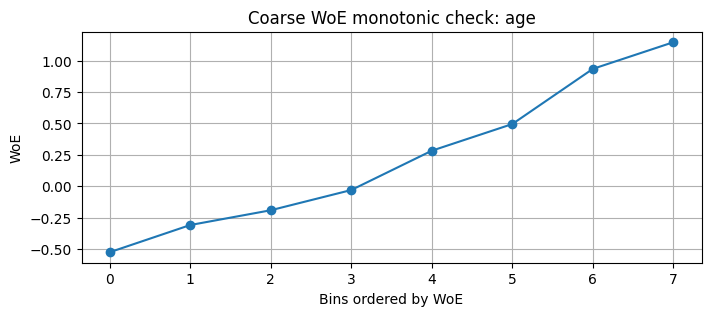

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,16671,14870,1801,0.151763,0.256626,-0.525302,0.055085,0.108032,0.239609
1,G2,15158,13811,1347,0.140954,0.191935,-0.308720,0.015739,0.088864,0.239609
2,G3,17284,15905,1379,0.162326,0.196495,-0.191031,0.006527,0.079785,0.239609
3,G4,15044,14010,1034,0.142985,0.147335,-0.029969,0.000130,0.068732,0.239609
4,G5,9375,8895,480,0.090782,0.068396,0.283153,0.006339,0.051200,0.239609
5,G6,11576,11092,484,0.113204,0.068966,0.495589,0.021924,0.041811,0.239609
6,G7,9908,9637,271,0.098355,0.038615,0.934941,0.055853,0.027352,0.239609
7,G8,9984,9762,222,0.099631,0.031633,1.147270,0.078012,0.022236,0.239609


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


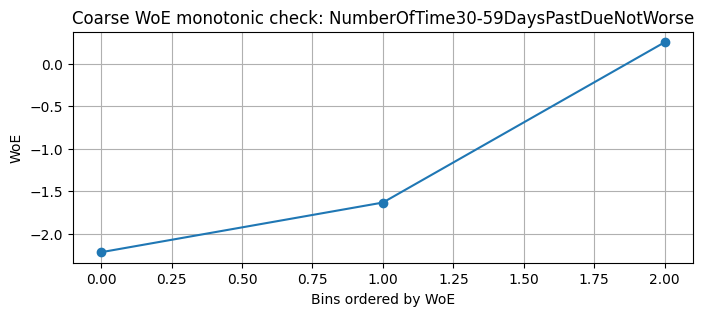

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,2345,1413,932,0.014421,0.132801,-2.220168,0.262824,0.397441,0.481024
1,G2,3225,2359,866,0.024076,0.123397,-1.634197,0.162310,0.268527,0.481024
2,G3,99430,94210,5220,0.961503,0.743802,0.256723,0.055889,0.052499,0.481024


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


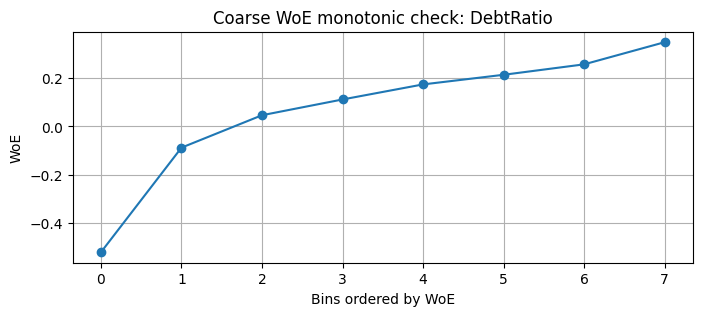

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15750,14056,1694,0.143455,0.241379,-0.520349,0.050955,0.107556,0.077643
1,G2,15749,14607,1142,0.149078,0.162724,-0.087586,0.001195,0.072513,0.077643
2,G3,15753,14745,1008,0.150487,0.143631,0.046630,0.000320,0.063988,0.077643
3,G4,15750,14802,948,0.151069,0.135081,0.111858,0.001788,0.060190,0.077643
4,G5,10500,9904,596,0.101080,0.084924,0.174148,0.002813,0.056762,0.077643
5,G6,10500,9926,574,0.101304,0.081790,0.213978,0.004176,0.054667,0.077643
6,G7,10500,9949,551,0.101539,0.078512,0.257187,0.005922,0.052476,0.077643
7,G8,10498,9993,505,0.101988,0.071958,0.348776,0.010474,0.048104,0.077643


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


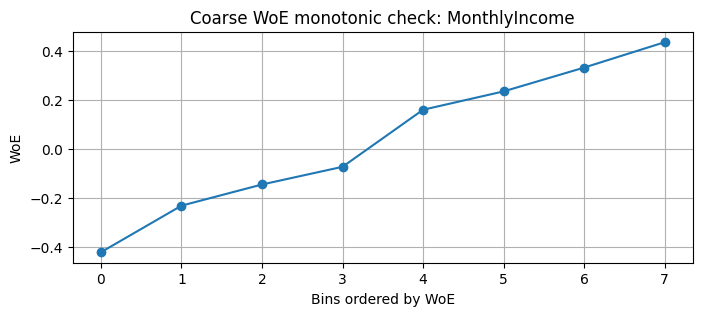

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15863,14300,1563,0.145945,0.222713,-0.422653,0.032446,0.098531,0.077518
1,G2,10461,9594,867,0.097916,0.123539,-0.232451,0.005956,0.082879,0.077518
2,G3,10270,9484,786,0.096793,0.111998,-0.145901,0.002218,0.076534,0.077518
3,G4,9709,9014,695,0.091996,0.099031,-0.073683,0.000518,0.071583,0.077518
4,G5,27226,25659,1567,0.261875,0.223283,0.159426,0.006153,0.057555,0.077518
5,G6,10500,9937,563,0.101417,0.080222,0.234435,0.004969,0.053619,0.077518
6,G7,10472,9960,512,0.101651,0.072955,0.331702,0.009519,0.048892,0.077518
7,G8,10499,10034,465,0.102407,0.066258,0.435392,0.015739,0.044290,0.077518


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


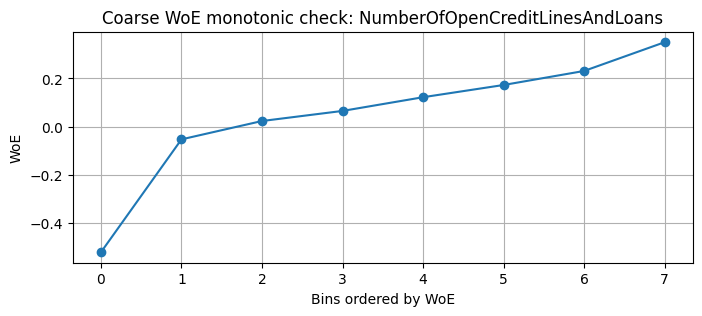

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15360,13706,1654,0.139883,0.235680,-0.521668,0.049974,0.107682,0.071222
1,G2,10383,9654,729,0.098528,0.103876,-0.052852,0.000283,0.070211,0.071222
2,G3,13227,12362,865,0.126166,0.123254,0.023348,0.000068,0.065397,0.071222
3,G4,13931,13055,876,0.133239,0.124822,0.065255,0.000549,0.062881,0.071222
4,G5,14679,13804,875,0.140883,0.124679,0.122184,0.001980,0.059609,0.071222
5,G6,18812,17743,1069,0.181084,0.152323,0.172962,0.004975,0.056825,0.071222
6,G7,9799,9272,527,0.094630,0.075093,0.231248,0.004518,0.053781,0.071222
7,G8,8809,8386,423,0.085587,0.060274,0.350641,0.008876,0.048019,0.071222


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


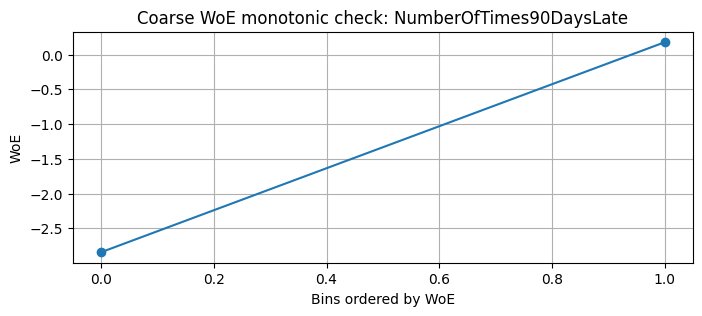

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,2174,975,1199,0.009951,0.170846,-2.843111,0.457444,0.551518,0.485979
1,G2,102826,97007,5819,0.990049,0.829154,0.177349,0.028535,0.056591,0.485979


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


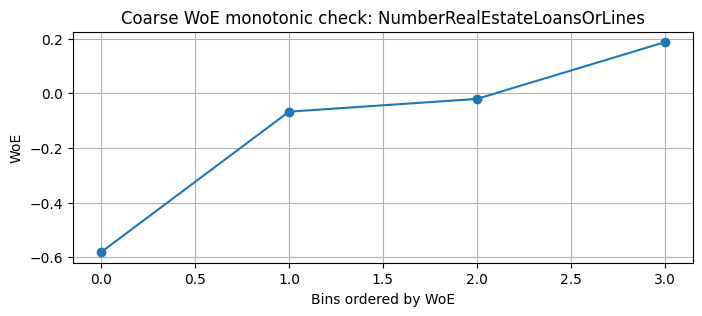

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,2544,2255,289,0.023014,0.041180,-0.581827,0.010569,0.113601,0.017854
1,G2,4426,4111,315,0.041957,0.044885,-0.067457,0.000198,0.071170,0.017854
2,G3,75924,70750,5174,0.722071,0.737247,-0.020799,0.000316,0.068147,0.017854
3,G4,22106,20866,1240,0.212957,0.176689,0.186704,0.006772,0.056093,0.017854


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


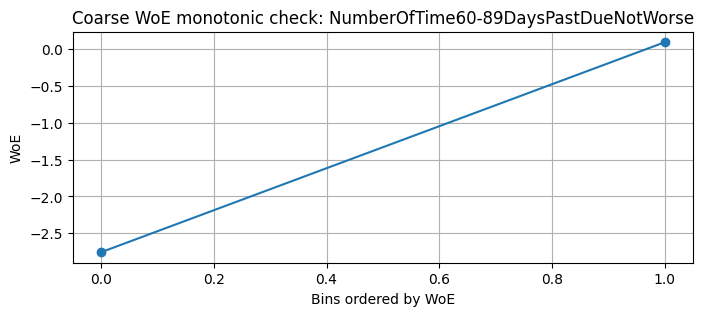

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,1289,605,684,0.006175,0.097464,-2.759035,0.251870,0.530644,0.260666
1,G2,103711,97377,6334,0.993825,0.902536,0.096353,0.008796,0.061074,0.260666


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


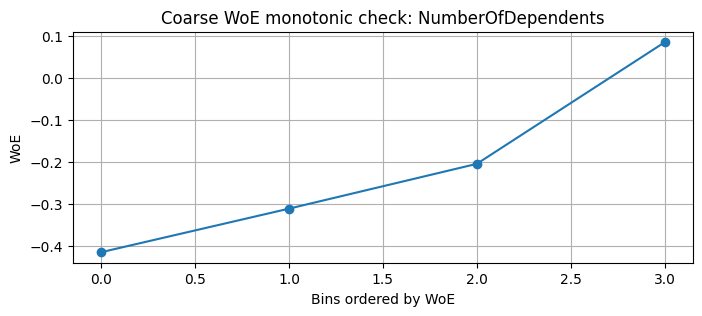

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,2708,2443,265,0.024933,0.037760,-0.415053,0.005324,0.097858,0.023785
1,G2,6647,6055,592,0.061797,0.084355,-0.311172,0.007019,0.089063,0.023785
2,G3,13644,12542,1102,0.128003,0.157025,-0.204349,0.005931,0.080768,0.023785
3,G4,82001,76942,5059,0.785267,0.720861,0.085578,0.005512,0.061694,0.023785


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


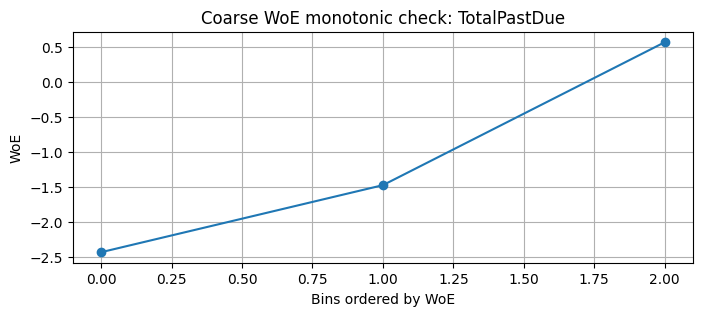

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,5048,2785,2263,0.028424,0.322457,-2.428749,0.714132,0.448296,1.101913
1,G2,4181,3185,996,0.032506,0.141921,-1.473845,0.161260,0.238221,1.101913
2,G3,95771,92012,3759,0.939070,0.535623,0.561461,0.226520,0.039250,1.101913


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


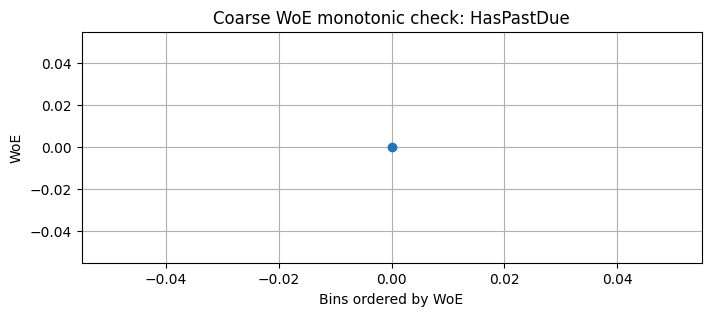

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,105000,97982,7018,1.0,1.0,0.0,0.0,0.066838,0.0


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


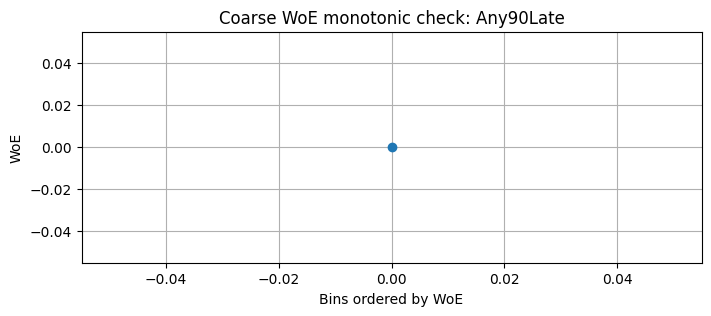

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,105000,97982,7018,1.0,1.0,0.0,0.0,0.066838,0.0


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


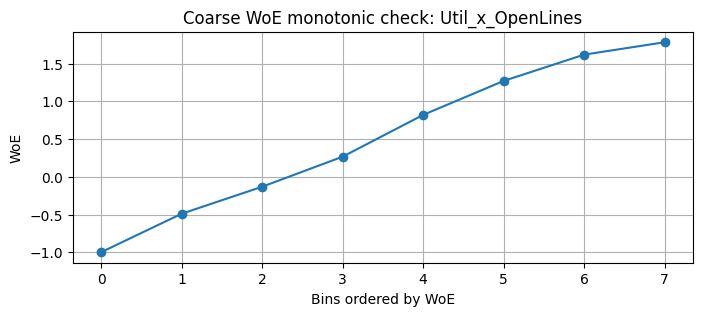

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15750,13187,2563,0.134586,0.365204,-0.998252,0.230215,0.162730,0.72459
1,G2,15750,14103,1647,0.143935,0.234682,-0.488873,0.044364,0.104571,0.72459
2,G3,15750,14561,1189,0.148609,0.169421,-0.131071,0.002728,0.075492,0.72459
3,G4,15750,14931,819,0.152385,0.116700,0.266805,0.009521,0.052000,0.72459
4,G5,10500,10179,321,0.103886,0.045740,0.820335,0.047700,0.030571,0.72459
5,G6,10500,10293,207,0.105050,0.029496,1.270195,0.095969,0.019714,0.72459
6,G7,10500,10353,147,0.105662,0.020946,1.618294,0.137096,0.014000,0.72459
7,G8,10500,10375,125,0.105887,0.017811,1.782535,0.156998,0.011905,0.72459


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


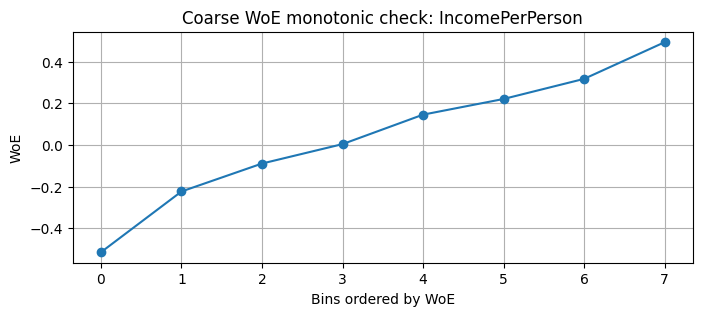

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,15896,14195,1701,0.144874,0.242377,-0.514632,0.050178,0.107008,0.097751
1,G2,10502,9639,863,0.098375,0.122970,-0.223148,0.005488,0.082175,0.097751
2,G3,10453,9694,759,0.098937,0.108150,-0.089045,0.000820,0.072611,0.097751
3,G4,10574,9870,704,0.100733,0.100313,0.004171,0.000002,0.066578,0.097751
4,G5,10495,9883,612,0.100865,0.087204,0.145534,0.001988,0.058313,0.097751
5,G6,26217,24793,1424,0.253036,0.202907,0.220786,0.011068,0.054316,0.097751
6,G7,10531,10009,522,0.102151,0.074380,0.317267,0.008811,0.049568,0.097751
7,G8,10332,9899,433,0.101029,0.061698,0.493146,0.019396,0.041909,0.097751


/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]
/tmp/ipython-input-2850283243.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("bin", dropna=False)["y"]


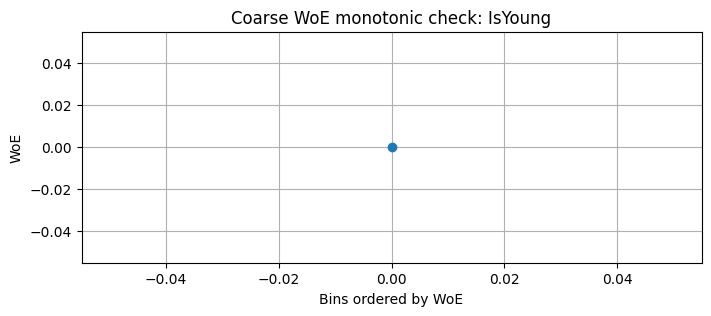

,bin,total,good,bad,dist_good,dist_bad,woe,iv,bad_rate,iv_total
0,G1,105000,97982,7018,1.0,1.0,0.0,0.0,0.066838,0.0


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalPastDue,HasPastDue,Any90Late,Util_x_OpenLines,IncomePerPerson,IsYoung
138985,1.058317,-0.191031,0.256723,0.046630,-0.145901,0.065255,0.177349,-0.020799,0.096353,0.085578,0.561461,0.0,0.0,0.266805,0.145534,0.0
63964,1.653382,-0.308720,0.256723,-0.087586,-0.422653,0.023348,0.177349,-0.020799,0.096353,0.085578,0.561461,0.0,0.0,1.618294,-0.514632,0.0
46077,1.653382,-0.308720,0.256723,-0.520349,-0.422653,0.231248,0.177349,-0.020799,0.096353,0.085578,0.561461,0.0,0.0,1.618294,-0.089045,0.0
83030,-0.516374,0.283153,0.256723,0.213978,0.331702,-0.052852,0.177349,-0.581827,0.096353,0.085578,0.561461,0.0,0.0,-0.998252,0.493146,0.0
11184,-0.516374,-0.525302,0.256723,-0.087586,-0.073683,0.122184,0.177349,-0.067457,0.096353,0.085578,0.561461,0.0,0.0,-0.998252,-0.089045,0.0


In [47]:
feature_cols = X_train.columns.tolist()

woe_maps = {}
bins_maps = {}

X_train_woe = pd.DataFrame(index=X_train.index)
X_test_woe  = pd.DataFrame(index=X_test.index)

for col in feature_cols:
    fb = fine_binning(X_train[col], n_bins=20)

    cb = coarse_from_fine(fb, y_train, max_bins=8)

    tab = woe_table_for_binned(cb, y_train)
    plot_woe_monotonic(tab, f"Coarse WoE monotonic check: {col}")
    display(tab)

    wmap = woe_map_from_bins(cb.astype(str), y_train)
    woe_maps[col] = wmap

    X_train_woe[col] = cb.astype(str).map(wmap).astype(float)

    fb_test = fine_binning(X_test[col], n_bins=20)
    fine_tab = woe_table_for_binned(fb.astype(str), y_train)
    fine_order = fine_tab["bin"].tolist()
    k = min(8, len(fine_order))
    fine_groups = np.array_split(fine_order, k)
    fine_to_group = {}
    for i, grp in enumerate(fine_groups):
        for b in grp:
            fine_to_group[b] = f"G{i+1}"

    test_groups = fb_test.astype(str).map(fine_to_group).astype("category")
    X_test_woe[col] = test_groups.astype(str).map(wmap).astype(float)

X_train_woe = X_train_woe.fillna(0)
X_test_woe = X_test_woe.fillna(0)

display(X_train_woe.head())

In [48]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_woe, y_train)

p_train = lr.predict_proba(X_train_woe)[:, 1]
p_test  = lr.predict_proba(X_test_woe)[:, 1]

print("ROC AUC train:", roc_auc_score(y_train, p_train))
print("ROC AUC test :", roc_auc_score(y_test, p_test))

pred = (p_test >= 0.5).astype(int)
print("F1:", f1_score(y_test, pred))
print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

ROC AUC train: 0.8414994439600775
ROC AUC test : 0.7744345672921996
F1: 0.04361770365618987
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     41992
           1       0.62      0.02      0.04      3008

    accuracy                           0.93     45000
   macro avg       0.78      0.51      0.50     45000
weighted avg       0.91      0.93      0.90     45000

Confusion matrix:
 [[41950    42]
 [ 2940    68]]


Factor: 28.85390081777927 Offset: 487.1228762045055


,0
31294,442.658178
96643,399.541137
144649,383.755508
96911,396.066129
120437,389.865260


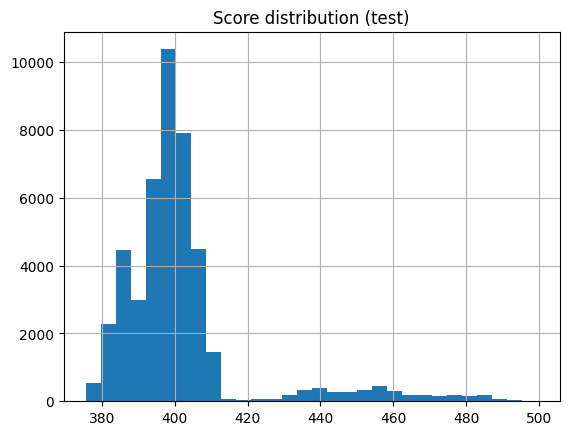

,feature,woe,beta,score_points
10,TotalPastDue,-1.473845,-0.727235,56.636538
1,age,-0.191031,-0.429839,28.079262
2,NumberOfTime30-59DaysPastDueNotWorse,0.256723,0.102919,26.472367
7,NumberRealEstateLoansOrLines,-0.020799,-0.967447,26.290598
3,DebtRatio,0.000000,-0.526162,25.710000
4,MonthlyIncome,0.000000,-0.316708,25.710000
11,HasPastDue,0.000000,0.000000,25.710000
0,RevolvingUtilizationOfUnsecuredLines,0.000000,-0.520195,25.710000
14,IncomePerPerson,0.000000,-0.021299,25.710000
15,IsYoung,0.000000,0.000000,25.710000


Total score: 442.6581784856862
PD estimate: 0.17638573927634496


In [49]:

PDO = 20
TargetScore = 600
TargetOdds = 50

Factor = PDO / np.log(2)
Offset = TargetScore - Factor * np.log(TargetOdds)

n = X_train_woe.shape[1]
alpha = lr.intercept_[0]
betas = pd.Series(lr.coef_[0], index=X_train_woe.columns)

print("Factor:", Factor, "Offset:", Offset)


base_per_feature = (alpha / n) * Factor + (Offset / n)


def score_from_woe(col, woe_val):
    return (betas[col] * woe_val) * Factor + base_per_feature


def score_row(woe_row: pd.Series) -> float:
    s = 0.0
    for c, w in woe_row.items():
        s += score_from_woe(c, w)
    return float(s)

scores_test = X_test_woe.apply(score_row, axis=1)
display(scores_test.head())

plt.figure()
scores_test.hist(bins=30)
plt.title("Score distribution (test)")
plt.show()

i = X_test_woe.index[0]
row = X_test_woe.loc[i]
contrib = pd.DataFrame({
    "feature": row.index,
    "woe": row.values,
    "beta": betas[row.index].values,
    "score_points": [score_from_woe(c, w) for c, w in row.items()]
}).sort_values("score_points", ascending=False)

display(contrib)
print("Total score:", score_row(row))
print("PD estimate:", lr.predict_proba(X_test_woe.loc[[i]])[0,1])

WoE transformation was applied to all features, and monotonicity of WoE was achieved after coarse binning.
A logistic regression model was built using WoE variables, which is suitable for credit scoring tasks.
The model shows good discriminatory power with ROC AUC ≈ 0.77 on the test sample, while no strong overfitting is observed.
A scorecard was constructed, allowing to clearly interpret the contribution of each feature to the final client score.


Conduct a sample stability analysis using PSI
- Compare the test and training samples you downloaded from Kaggle (df_train, df_test)

# 4. Using methods to reduce class imbalance - (Task weight: 20%)
- Try several methods to reduce class imbalance
- Choose the one that brings the greatest improvement

,feature,psi
4,MonthlyIncome,0.000398
14,IncomePerPerson,0.000261
13,Util_x_OpenLines,0.000139
9,NumberOfDependents,0.000136
0,RevolvingUtilizationOfUnsecuredLines,0.000124
3,DebtRatio,0.000119
1,age,0.000117
5,NumberOfOpenCreditLinesAndLoans,0.000113
7,NumberRealEstateLoansOrLines,0.000086
2,NumberOfTime30-59DaysPastDueNotWorse,0.000018


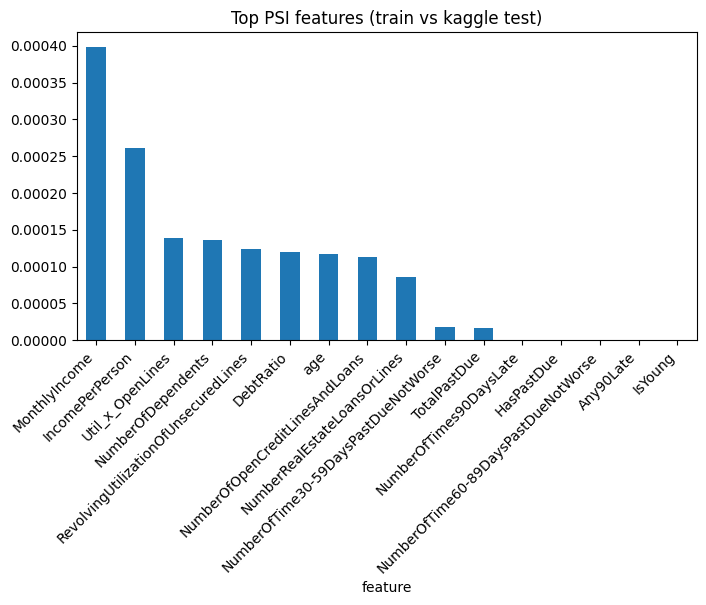

In [50]:
def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins: int = 10, eps: float = 1e-6) -> float:
    a = train_s.replace([np.inf, -np.inf], np.nan).dropna()
    b = test_s.replace([np.inf, -np.inf], np.nan).dropna()

    try:
        cuts = pd.qcut(a, q=bins, duplicates="drop")
        edges = cuts.cat.categories

        bin_edges = [-np.inf] + [iv.right for iv in edges]
    except Exception:
        bin_edges = np.linspace(a.min(), a.max(), bins+1)

    a_bins = pd.cut(a, bins=bin_edges, include_lowest=True)
    b_bins = pd.cut(b, bins=bin_edges, include_lowest=True)

    a_dist = a_bins.value_counts(normalize=True).sort_index()
    b_dist = b_bins.value_counts(normalize=True).sort_index()

    idx = a_dist.index.union(b_dist.index)
    a_dist = a_dist.reindex(idx, fill_value=0) + eps
    b_dist = b_dist.reindex(idx, fill_value=0) + eps

    psi = np.sum((a_dist - b_dist) * np.log(a_dist / b_dist))
    return float(psi)

psi_list = []
for col in X.columns:
    if col in df_test2.columns:
        val = psi_for_series(df_train2[col], df_test2[col], bins=10)
        psi_list.append((col, val))

psi_df = pd.DataFrame(psi_list, columns=["feature", "psi"]).sort_values("psi", ascending=False)
display(psi_df)

plt.figure(figsize=(8,4))
psi_df.set_index("feature")["psi"].head(20).plot(kind="bar")
plt.title("Top PSI features (train vs kaggle test)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [51]:
!pip install imbalanced-learn -q

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

PSI values for all features are very low, indicating no significant data drift between train and test samples.
The largest PSI is observed for income-related variables, but the values remain far below critical thresholds.
Overall, the model can be considered stable and suitable for further use without recalibration.

_Optional, for those who have reached the end of the laptop_ 😊

What was your impression of the work?
What was difficult?
What was interesting?

Overall, the assignment was useful because this topic is closely related to other projects I am working on during the course.

It helped me better understand how data analysis and modeling are applied in real business tasks)

The knowledge from this work can be reused in other course projects, especially those related to analytics and decision making 😄

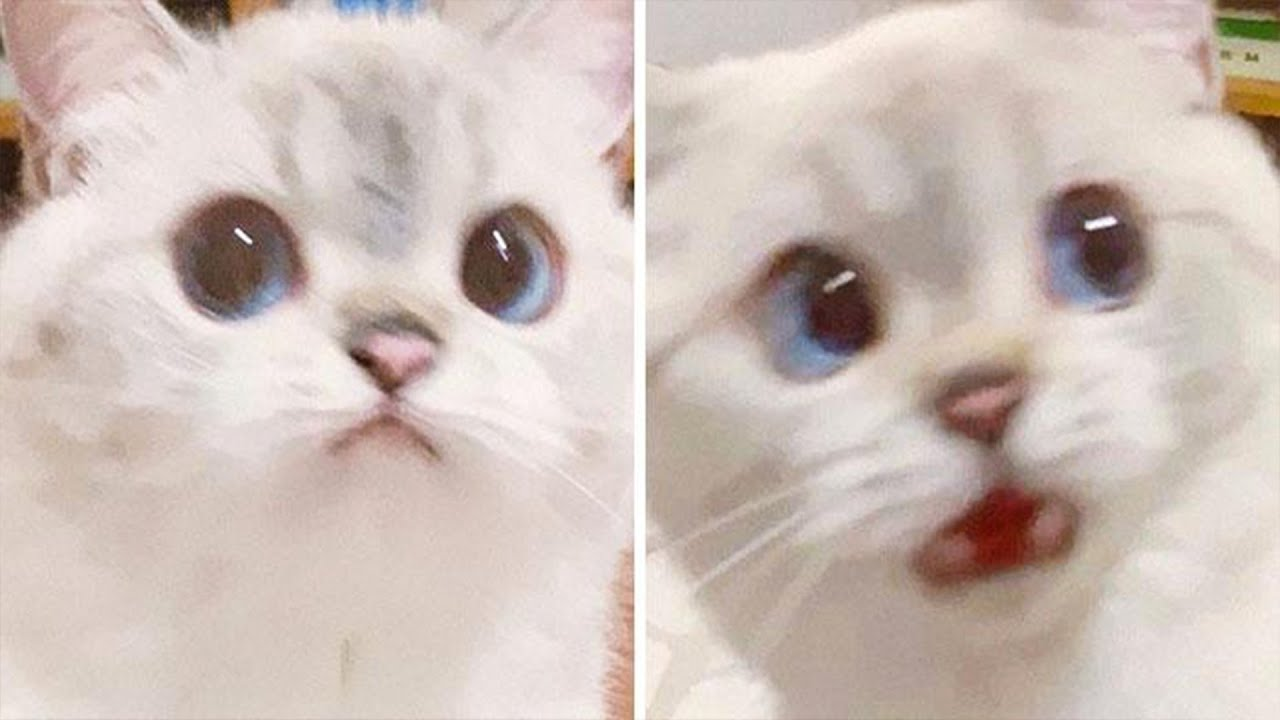